In [3]:
import numpy as np #
import pandas as pd 

import os
print(os.listdir("./data"))

# Any results you write to the current directory are saved as output.

import warnings
warnings.filterwarnings('ignore')
import gc
gc.collect()

['wiki', 'wiki.tar.gz', 'appa-real-release.zip', 'crop_part1', 'UTKFace.tar.gz', 'appa-real-release', 'crop_part1.tar.gz']


20

In [5]:
!pip install pretrainedmodels

     |████████████████████████████████| 61kB 1.0MB/s eta 0:00:01
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp37-none-any.whl size=60962 sha256=a389c9a93b9a8874c461af46ab7aa6236564f87afab5c83dda3ffa9f06613e33
  Stored in directory: /home/jdemlow/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built pretrainedmodels


In [37]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import fastai

from fastai import *
from fastai.vision import *

from torchvision.models import *
import pretrainedmodels

import sys

from fastai.callbacks.hooks import *

from fastai.callbacks.tracker import EarlyStoppingCallback
from fastai.callbacks.tracker import SaveModelCallback

import scipy.io
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

  

In [38]:
mat_wiki = scipy.io.loadmat(f'{path_wiki}/wiki.mat')
mat_imdb = scipy.io.loadmat(f'{path_imdb}/imdb.mat')

In [39]:
columns = ["dob", "photo_taken", "full_path", "gender", "name", "face_location", 
           "face_score", "second_face_score", 'celeb_names', 'celeb_id']

In [40]:
mat_wiki['wiki'][0][0][0].shape[1]

62328

In [41]:
instances_wiki = mat_wiki['wiki'][0][0][0].shape[1]
instances_imdb = mat_imdb['imdb'][0][0][0].shape[1]


df_wiki = pd.DataFrame(index = range(0,instances_wiki), columns = columns)
df_imdb = pd.DataFrame(index = range(0,instances_imdb), columns = columns)

In [42]:
for i in mat_wiki:
    if i == "wiki":
        current_array = mat_wiki[i][0][0]
        for j in range(len(current_array)):
            #print(columns[j],": ",current_array[j])
            df_wiki[columns[j]] = pd.DataFrame(current_array[j][0])
            

for i in mat_imdb:
    if i == "imdb":
        current_array = mat_imdb[i][0][0]
        for j in range(len(current_array)):
            #print(columns[j],": ",current_array[j])
            df_imdb[columns[j]] = pd.DataFrame(current_array[j][0])

In [43]:
df_wiki.head()

,dob,photo_taken,full_path,gender,name,face_location,face_score,second_face_score,celeb_names,celeb_id
0,723671,2009,[17/10000217_1981-05-05_2009.jpg],1.0,[Sami Jauhojärvi],"[[111.29109473290997, 111.29109473290997, 252....",4.300962,NaN,NaN,NaN
1,703186,1964,[48/10000548_1925-04-04_1964.jpg],1.0,[Dettmar Cramer],"[[252.48330229530742, 126.68165114765371, 354....",2.645639,1.949248,NaN,NaN
2,711677,2008,[12/100012_1948-07-03_2008.jpg],1.0,[Marc Okrand],"[[113.52, 169.83999999999997, 366.08, 422.4]]",4.329329,NaN,NaN,NaN
3,705061,1961,[65/10001965_1930-05-23_1961.jpg],1.0,[Aleksandar Matanović],"[[1, 1, 634, 440]]",-inf,NaN,NaN,NaN
4,720044,2012,[16/10002116_1971-05-31_2012.jpg],0.0,[Diana Damrau],"[[171.61031405173117, 75.57451239763239, 266.7...",3.408442,NaN,NaN,NaN


In [44]:
df_imdb.head()

,dob,photo_taken,full_path,gender,name,face_location,face_score,second_face_score,celeb_names,celeb_id
0,693726,1968,[01/nm0000001_rm124825600_1899-5-10_1968.jpg],1.0,[Fred Astaire],"[[1072.926, 161.838, 1214.7839999999999, 303.6...",1.459693,1.118973,['Lee' George Quinones],6488
1,693726,1970,[01/nm0000001_rm3343756032_1899-5-10_1970.jpg],1.0,[Fred Astaire],"[[477.184, 100.352, 622.592, 245.76]]",2.543198,1.852008,['Weird Al' Yankovic],6488
2,693726,1968,[01/nm0000001_rm577153792_1899-5-10_1968.jpg],1.0,[Fred Astaire],"[[114.96964308962852, 114.96964308962852, 451....",3.455579,2.985660,[2 Chainz],6488
3,693726,1968,[01/nm0000001_rm946909184_1899-5-10_1968.jpg],1.0,[Fred Astaire],"[[622.8855056426588, 424.21750383700805, 844.3...",1.872117,NaN,[50 Cent],6488
4,693726,1968,[01/nm0000001_rm980463616_1899-5-10_1968.jpg],1.0,[Fred Astaire],"[[1013.8590023603723, 233.8820422075853, 1201....",1.158766,NaN,[A Martinez],6488


In [45]:
df_wiki.shape, df_imdb.shape

((62328, 10), (460723, 10))

In [46]:
def datenum_to_datetime(datenum):
    
    try:
        days = datenum % 1
        hours = days % 1 * 24
        minutes = hours % 1 * 60
        seconds = minutes % 1 * 60
        exact_date = datetime.fromordinal(int(datenum)) \
           + timedelta(days=int(days)) \
           + timedelta(hours=int(hours)) \
           + timedelta(minutes=int(minutes)) \
           + timedelta(seconds=round(seconds)) \
           - timedelta(days=366)
    
        return exact_date.year
    
    except(ValueError, TypeError, OverflowError):
        
        return np.nan

In [47]:
df_wiki['date_of_birth'] = df_wiki['dob'].apply(datenum_to_datetime) 
df_imdb['date_of_birth'] = df_imdb['dob'].apply(datenum_to_datetime)

In [48]:
df_wiki['date_of_birth'].value_counts()
df_imdb['date_of_birth'].value_counts()

1969.0    16511
1978.0    16062
1971.0    15344
1976.0    14232
1970.0    14184
          ...  
1879.0        1
2012.0        1
1883.0        1
1888.0        1
1732.0        1
Name: date_of_birth, Length: 128, dtype: int64

In [49]:
df_wiki['age'] = df_wiki['photo_taken'] - df_wiki['date_of_birth']
#remove pictures does not include face
df_wiki = df_wiki[df_wiki['face_score'] != -np.inf]
#Some pictures include more than one face, remove them
df_wiki = df_wiki[df_wiki['second_face_score'].isna()]
#check threshold
df_wiki = df_wiki[df_wiki['face_score'] >= 3.5]
df_wiki = df_wiki.drop(columns = ['name','face_score','second_face_score','date_of_birth','face_location'])
#some guys seem to be greater than 100. some of these are paintings. remove these old guys
df_wiki = df_wiki[df_wiki['age'] <= 100]
#some guys seem to be unborn in the data set
df_wiki = df_wiki[df_wiki['age'] > 0]

In [50]:
df_imdb['age'] = df_imdb['photo_taken'] - df_imdb['date_of_birth']
#remove pictures does not include face
df_imdb = df_imdb[df_imdb['face_score'] != -np.inf]
#some pictures include more than one face, remove them
df_imdb = df_imdb[df_imdb['second_face_score'].isna()]
#check threshold
df_imdb = df_imdb[df_imdb['face_score'] >= 3.5]
df_imdb = df_imdb.drop(columns = ['name','face_score','second_face_score','date_of_birth','face_location'])
#some guys seem to be greater than 100. some of these are paintings. remove these old guys
df_imdb = df_imdb[df_imdb['age'] <= 100]
#some guys seem to be unborn in the data set
df_imdb = df_imdb[df_imdb['age'] > 0]

In [51]:
df_wiki.head()

,dob,photo_taken,full_path,gender,celeb_names,celeb_id,age
0,723671,2009,[17/10000217_1981-05-05_2009.jpg],1.0,NaN,NaN,28
2,711677,2008,[12/100012_1948-07-03_2008.jpg],1.0,NaN,NaN,60
5,716189,2012,[02/10002702_1960-11-09_2012.jpg],0.0,NaN,NaN,52
6,707745,1971,[41/10003541_1937-09-27_1971.jpg],1.0,NaN,NaN,34
10,697114,1950,[99/10004299_1908-08-19_1950.jpg],1.0,NaN,NaN,42


In [52]:
df_wiki.shape, df_imdb.shape

((17096, 7), (73683, 7))

In [53]:
df_wiki['age'] = df_wiki['age'].apply(lambda x: int(x))
df_imdb['age'] = df_imdb['age'].apply(lambda x: int(x))

In [54]:
print(type(df_wiki['age']))
df_wiki['age'].value_counts()
df_imdb['age'].value_counts()

<class 'pandas.core.series.Series'>


31    2757
32    2677
29    2578
33    2545
30    2532
      ... 
96       1
95       1
93       1
92       1
3        1
Name: age, Length: 98, dtype: int64

In [55]:
df_wiki = df_wiki.drop(columns=['dob', 'photo_taken'])
df_imdb = df_imdb.drop(columns=['dob', 'photo_taken'])

In [56]:
df_age_wiki = df_wiki.drop(columns=['gender', 'celeb_names', 'celeb_id'])
df_age_imdb = df_imdb.drop(columns=['gender', 'celeb_names', 'celeb_id'])

In [57]:
df_age_wiki['full_path'] = df_age_wiki['full_path'].str.get(0)
df_age_imdb['full_path'] = df_age_imdb['full_path'].str.get(0)

In [58]:
df_age_wiki.dropna(axis=0, inplace=True)
df_age_imdb.dropna(axis=0, inplace=True)

In [59]:
df_age_wiki.head()

,full_path,age
0,17/10000217_1981-05-05_2009.jpg,28
2,12/100012_1948-07-03_2008.jpg,60
5,02/10002702_1960-11-09_2012.jpg,52
6,41/10003541_1937-09-27_1971.jpg,34
10,99/10004299_1908-08-19_1950.jpg,42


In [60]:
df_age_imdb.head()

,full_path,age
7,02/nm0000002_rm1363385088_1924-9-16_2004.jpg,80
12,02/nm0000002_rm221957120_1924-9-16_1974.jpg,50
14,02/nm0000002_rm238734336_1924-9-16_1974.jpg,50
15,02/nm0000002_rm2585828096_1924-9-16_2006.jpg,82
18,02/nm0000002_rm2769394176_1924-9-16_2006.jpg,82


In [61]:
max_age = df_age_wiki["age"].max(); print(max_age)
min_age = df_age_wiki["age"].min(); print(min_age)

100
1


In [62]:
max_age = df_age_imdb["age"].max(); print(max_age)
min_age = df_age_imdb["age"].min(); print(min_age)

99
1


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4e43ef1990>]], dtype=object)

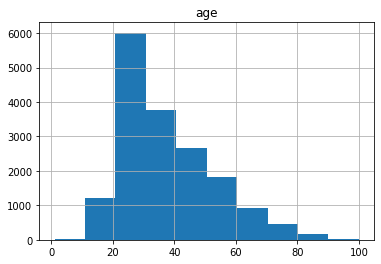

In [63]:
df_age_wiki.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4e19c66250>]], dtype=object)

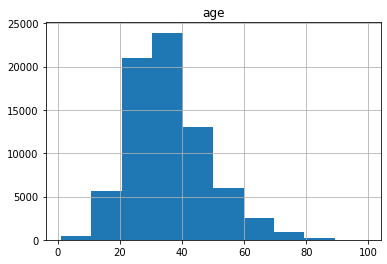

In [64]:
df_age_imdb.hist()

### Creating Data_Bunches

In [65]:
seed = 42
import numpy as np
np.random.seed(seed)

In [196]:
path_utk = Path('./data/crop_part1/')

In [199]:
Path('./data/crop_part1/')split

PosixPath('data/crop_part1')

In [210]:
def extract_age(filename):
    return float(filename.stem.split('_')[0])

**Transformations On Images**

In [67]:
#Ended up change this and got better resuls, but linux box failed and lost the code
tfms = get_transforms(max_rotate= 10.,max_zoom=1., max_lighting=0.20, do_flip=False,
                      max_warp=0., xtra_tfms=[flip_lr(), brightness(change=(0.3, 0.60), p=0.7),
                      contrast(scale=(0.5, 2), p=0.7), crop_pad(size=600, padding_mode='border', row_pct=0.,col_pct=0.),
                      rand_zoom(scale=(1.,1.5)), rand_crop(), perspective_warp(magnitude=(-0.1,0.1)),
                      symmetric_warp(magnitude=(-0.1,0.1)) ])

In [ ]:
path_wiki = Path('./data/wiki/')
path_imdb = Path('./data/imdb_crop/')

In [71]:
data_imdb = (ImageList.from_df(df_age_imdb, path_imdb, cols=['full_path'], folder ='.')
             .split_by_rand_pct(0.2, seed=42)
             .label_from_df(label_cls=FloatList)
             .transform(tfms, resize_method=ResizeMethod.CROP, padding_mode='border', size=128)
             .databunch(bs=64*2,num_workers=0).normalize(imagenet_stats))

data_imdb_big = (ImageList.from_df(df_age_imdb, path_imdb, cols=['full_path'], folder ='.')
             .split_by_rand_pct(0.2, seed=42)
             .label_from_df(label_cls=FloatList)
             .transform(tfms, resize_method=ResizeMethod.CROP, padding_mode='border', size=256)
             .databunch(bs=64*2,num_workers=0).normalize(imagenet_stats))

data_wiki = (ImageList.from_df(df_age_wiki, path_wiki, cols=['full_path'], folder ='.')
               .split_by_rand_pct(0.2, seed=42).label_from_df(label_cls=FloatList)
               .transform(tfms, resize_method=ResizeMethod.CROP, padding_mode='border', size=128)
               .databunch(bs=64*2,num_workers=0).normalize(imagenet_stats))
data_wiki_big = (ImageList.from_df(df_age_wiki, path_wiki, cols=['full_path'], folder ='.')
                 .split_by_rand_pct(0.2, seed=42).label_from_df(label_cls=FloatList)
                 .transform(tfms, resize_method=ResizeMethod.CROP, padding_mode='border', size=256)
                 .databunch(bs=64*2,num_workers=0).normalize(imagenet_stats))

In [212]:
data_utk = (ImageList.from_folder(path_utk)
                 .split_by_rand_pct(0.2, seed=42)
                 .label_from_func(extract_age, label_cls=FloatList)
                 .transform(tfms, resize_method=ResizeMethod.CROP, padding_mode='border', size=128)
                 .databunch(bs=64*2,num_workers=0)
                 .normalize(imagenet_stats))  

In [214]:
data_utk_big = (ImageList.from_folder(path_utk)
                 .split_by_rand_pct(0.2, seed=42)
                 .label_from_func(extract_age, label_cls=FloatList)
                 .transform(tfms, resize_method=ResizeMethod.CROP, padding_mode='border', size=256)
                 .databunch(bs=64*2,num_workers=0)
                 .normalize(imagenet_stats))

In [216]:
df_appa_train = pd.read_csv('./data/appa-real-release/gt_avg_train.csv')
df_appa_valid = pd.read_csv('./data/appa-real-release/gt_avg_valid.csv')
df_appa_test = pd.read_csv('./data/appa-real-release/gt_avg_test.csv')
df_app_train.tail(3)

,file_name,num_ratings,apparent_age_avg,apparent_age_std,real_age
4110,004110.jpg,131,36.923664,4.785585,35
4111,004111.jpg,12,26.833333,2.855086,28
4112,004112.jpg,68,19.455882,3.601135,20


In [217]:
df_list = [df_appa_train, df_appa_valid, df_appa_test]
drop = ['num_ratings', 'apparent_age_avg', 'apparent_age_std']
for x in df_list: 
    x.drop(drop, axis=1, inplace=True)

In [218]:
df_appa_train.shape, df_appa_valid.shape, df_appa_test.shape

((4113, 2), (1500, 2), (1978, 2))

In [219]:
df_appa = pd.concat([df_appa_train, df_appa_valid, df_appa_test])

In [221]:
df_appa.shape

(7591, 2)

In [222]:
df_appa['file_name'] = df_appa['file_name'].apply(lambda x: f"{x[:6]}.jpg_face{x[-4:]}")

In [223]:
df_appa.rename(columns = {"file_name":"full_path", "real_age":"age"}, inplace=True)
df_appa['age'] = df_appa['age'].apply(lambda x: int(float(x)))

In [225]:
df_appa.head()

,full_path,age
0,000000.jpg_face.jpg,4
1,000001.jpg_face.jpg,18
2,000002.jpg_face.jpg,80
3,000003.jpg_face.jpg,50
4,000004.jpg_face.jpg,17


In [112]:
# open_image('./data/appa-real-release/train/002741.jpg_face.jpg')
# open_image('./data/wiki/03/35109403_1993-04-14_2012.jpg')
# df_appa.to_csv('./data/appa-real-release/gt_full_data.csv', header=True, index=False)

In [231]:
path = Path('./data/appa-real-release/')
path_csv = './data/appa-real-release/gt_full_data.csv'
path_folder = './data/appa-real-release/'

data_appa = (ImageList.from_df(df_appa, path, cols=['full_path'], folder ='faces')
                    .split_by_rand_pct(0.2, seed=42)
                    .label_from_df(label_cls=FloatList)
                    .transform(tfms, resize_method=ResizeMethod.CROP, padding_mode='border', size=128)
                    .databunch(bs=64*2,num_workers=0)
                    .normalize(imagenet_stats))

In [235]:
data_appa_big = (ImageList.from_df(df_appa, path, cols=['full_path'], folder ='faces')
                    .split_by_rand_pct(0.2, seed=42)
                    .label_from_df(label_cls=FloatList)
                    .transform(tfms, resize_method=ResizeMethod.CROP, padding_mode='border', size=256)
                    .databunch(bs=64*2,num_workers=0)
                    .normalize(imagenet_stats))

# Data_Bunch Preview

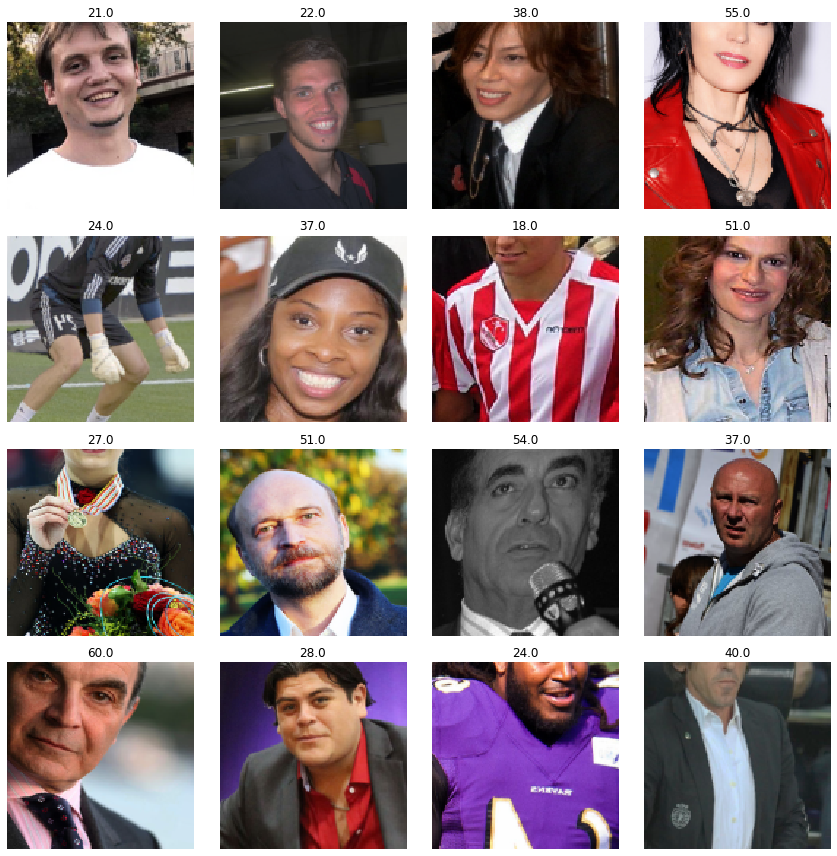

In [109]:
data_wiki.show_batch(4, figsize=(12,12))

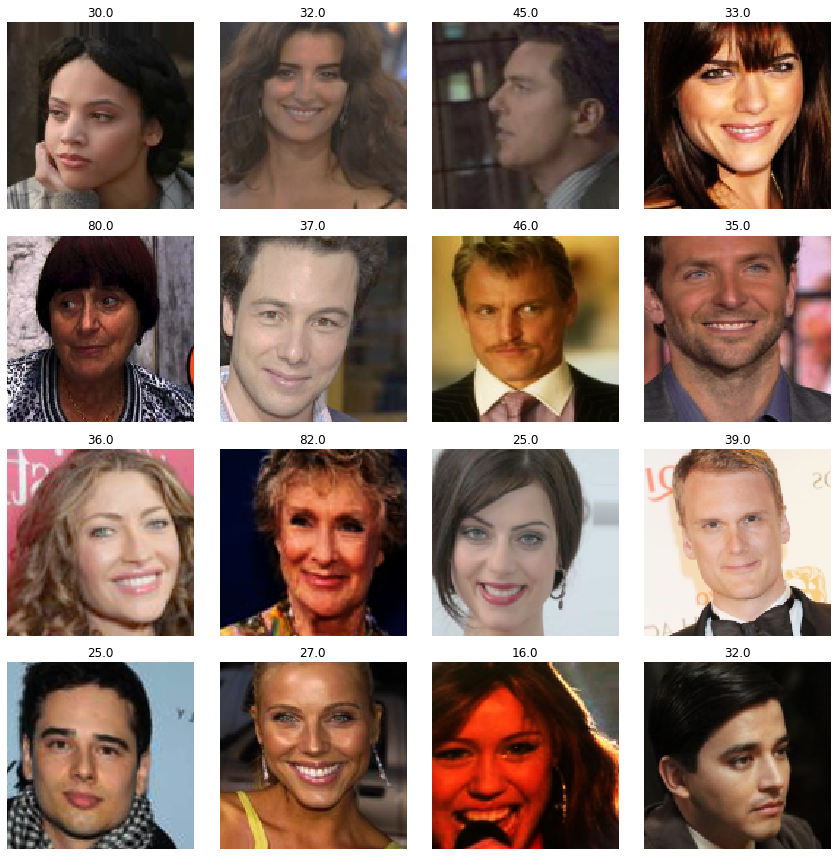

In [111]:
data_imdb.show_batch(4, figsize=(12,12))

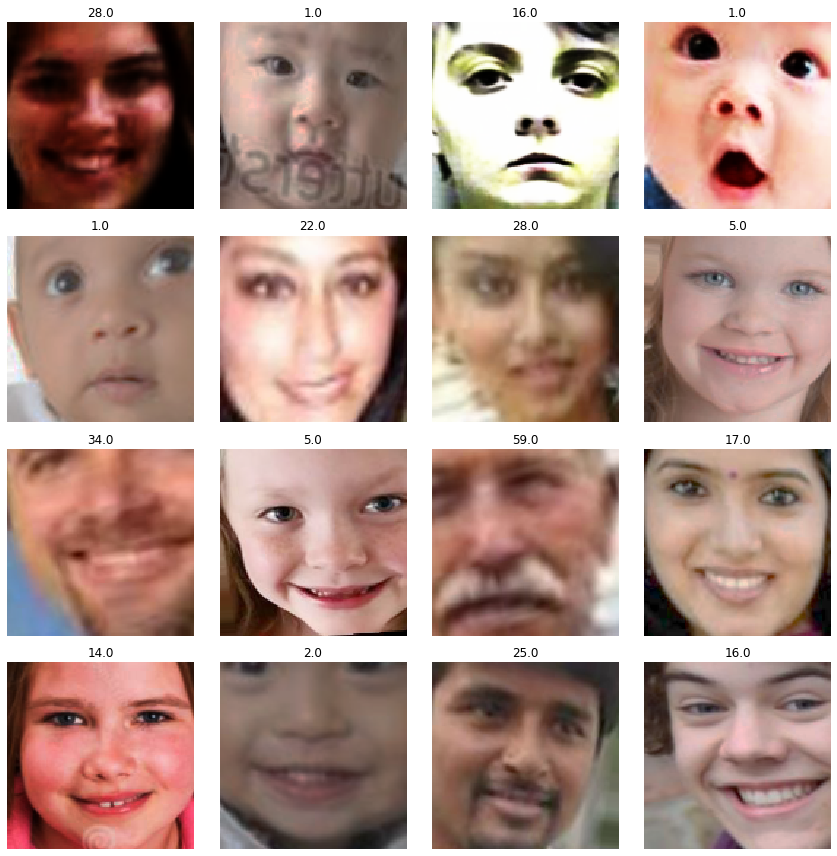

In [213]:
data_utk.show_batch(4, figsize=(12,12))

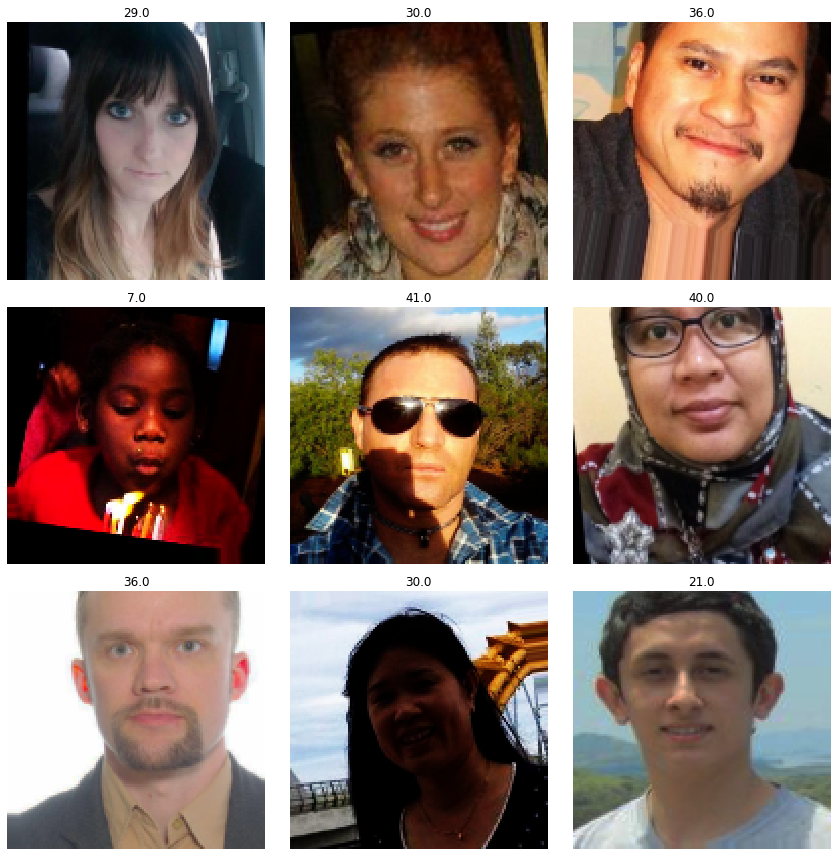

In [232]:
data_appa.show_batch(3, figsize=(12,12))

# Prepping Large Data Bunch

We need to make a large Data Bunch with all the data that we have in the 3 data bunch types that were created above. To do this we will first get a dataframe from the UTK data set as there isn't a dataset currently. There are other ways of doing this, but this a sneaky way taking advantage of fastai. 

Will concat all of these and build one large data bunch

```python
df_list = [df_appa, df_utk, df_age_wiki]
```

In [248]:
df_appa.head()

,full_path,age
0,000000.jpg_face.jpg,4
1,000001.jpg_face.jpg,18
2,000002.jpg_face.jpg,80
3,000003.jpg_face.jpg,50
4,000004.jpg_face.jpg,17


In [237]:
df_utk = data_utk.to_df()

In [238]:
df_utk.rename(columns = {"x":"full_path", "y":"age"}, inplace=True)
df_utk['age'] = df_utk['age'].apply(lambda x: int(float(x)))

In [239]:
df_utk.head()

,full_path,age
0,1_0_3_20161220144835319.jpg.chip.jpg,1
1,29_1_1_20170109134854367.jpg.chip.jpg,29
2,44_0_0_20170104201051081.jpg.chip.jpg,44
3,4_1_0_20170109192031317.jpg.chip.jpg,4
4,60_0_0_20170111202416395.jpg.chip.jpg,60


In [247]:
# we need to take the # / off 
df_age_wiki.head()

,full_path,age
0,10000217_1981-05-05_2009.jpg,28
2,100012_1948-07-03_2008.jpg,60
5,10002702_1960-11-09_2012.jpg,52
6,10003541_1937-09-27_1971.jpg,34
10,10004299_1908-08-19_1950.jpg,42


In [246]:
df_age_wiki['full_path'] = df_age_wiki['full_path'].str[3:]

In [262]:
df_age_imdb['full_path'] = df_age_imdb['full_path'].str[3:]

In [266]:
df_appa.shape, df_utk.shape, df_age_wiki.shape, df_age_imdb.shape

((7591, 2), (7824, 2), (17096, 2), (73683, 2))

In [285]:
# df_list = [df_appa, df_utk, df_age_wiki, df_age_imdb]
df_list = [df_appa, df_utk, df_age_wiki]
df = pd.concat(df_list)

In [286]:
df.shape #Note with imdb it's 100K pictures so for now I am stayingn with this

(32511, 2)

In [251]:
df.shape

(32511, 2)

# Moving Pictures to one folder

In [281]:
src_wiki = './data/wiki/'
src_utk = './data/crop_part1/'
src_appa = './data/appa-real-release/faces'
src_imdb = './data/imdb_crop/'
dest = './data/all/'

import os
import shutil
import pathlib

pathlib.Path(dest).mkdir(parents=True, exist_ok=True)

In [282]:
for root, dirs, files in os.walk(src_wiki):
    for file in files:
        path_file = os.path.join(root,file)
        shutil.copy2(path_file, dest)

In [283]:
for root, dirs, files in os.walk(src_utk):
    for file in files:
        path_file = os.path.join(root,file)
        shutil.copy2(path_file, dest)

In [284]:
for root, dirs, files in os.walk(src_appa):
    for file in files:
        path_file = os.path.join(root,file)
        shutil.copy2(path_file, dest)

In [261]:
for root, dirs, files in os.walk(src_imdb):
    for file in files:
        path_file = os.path.join(root,file)
        shutil.copy2(path_file, dest)

# Fastai Modeling

In [236]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
import random

In [267]:
opt_func = partial(optim.Adam, betas=(0.9,0.99), eps=1e-5)

def resnet(pretrained=False):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.resnet34(pretrained=pretrained)
    return model

class L1LossFlat(nn.SmoothL1Loss):
    def forward(self, input:Tensor, target:Tensor) -> Rank0Tensor:
        return super().forward(input.view(-1), target.view(-1))

In [268]:
class AgeModel(nn.Module):
    def __init__(self):
        super().__init__()
        layers = list(models.resnet34(pretrained=True).children())[:-2]
        layers += [AdaptiveConcatPool2d(), Flatten()]
        layers += [nn.BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
        layers += [nn.Dropout(p=0.50)]
        layers += [nn.Linear(1024, 512, bias=True), nn.ReLU(inplace=True)]
        layers += [nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
        layers += [nn.Dropout(p=0.50)]
        layers += [nn.Linear(512, 16, bias=True), nn.ReLU(inplace=True)]
        layers += [nn.Linear(16,1)]
        self.agemodel = nn.Sequential(*layers)
    def forward(self, x):
        return self.agemodel(x).squeeze(-1)
          # could add 116*torch.sigmoid

In [269]:
model = AgeModel()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/jdemlow/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:03<00:00, 24.3MB/s]


In [271]:
df.shape

(106194, 2)

In [272]:
# df.to_csv('./data/fulldataset.csv', header=True, index=False)

In [368]:
path = Path('./data/')
data_full_src = (ImageList.from_df(df, path, cols=['full_path'], folder ='all')
                    .split_by_rand_pct(0.2, seed=42)
                    .label_from_df(label_cls=FloatList))
#                     .transform(tfms, resize_method=ResizeMethod.CROP, padding_mode='border', size=128)
#                     .databunch(bs=64*2,num_workers=0)
#                     .normalize(imagenet_stats))

In [369]:
data_full = (data_full_src
             .transform(tfms, resize_method=ResizeMethod.CROP, padding_mode='border', size=128)
             .databunch(bs=64*2)
             .normalize(imagenet_stats))

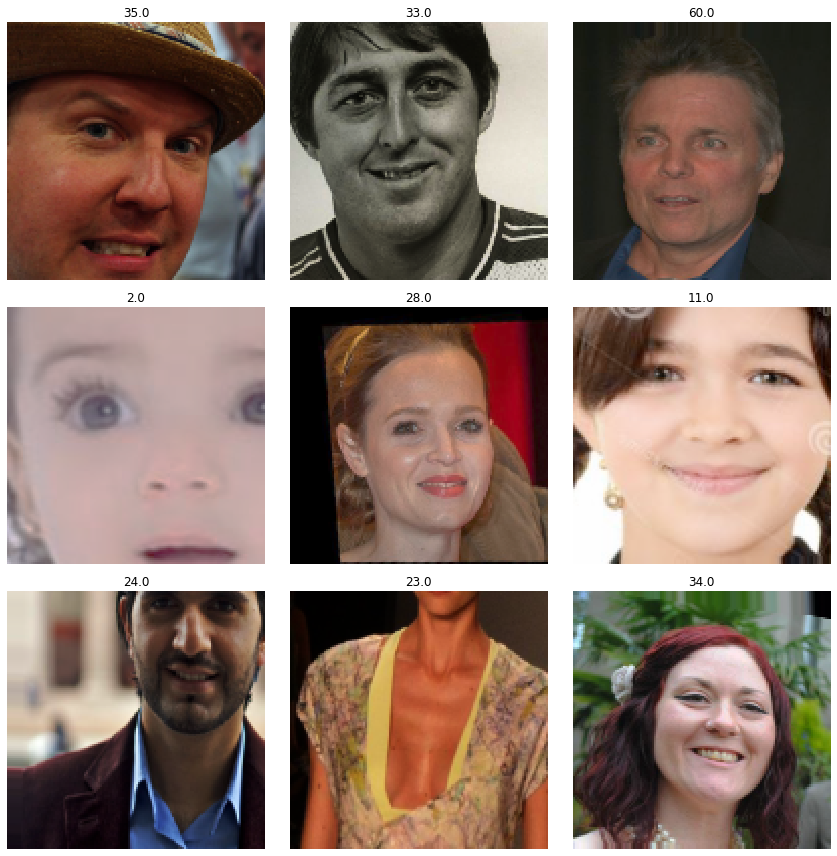

In [370]:
data_full.show_batch(3, figsize=(12,12))

In [373]:
learn = Learner(data_full, model, model_dir = "/tmp/model/", opt_func=opt_func, 
                bn_wd=False, metrics=[mean_absolute_error, root_mean_squared_error],
                callback_fns=[ShowGraph]).mixup(stack_y=False, alpha=0.2)

learn.loss_func = L1LossFlat()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-02
Min loss divided by 10: 4.37E-02


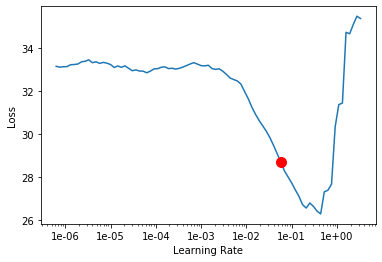

In [294]:
#train the head
learn.freeze_to(-1)
learn.lr_find()
learn.recorder.plot(suggestion = True)

epoch,train_loss,valid_loss,mean_absolute_error,root_mean_squared_error,time
0,11.712204,246.277008,246.767700,2265.856934,12:02
1,11.922296,15.657466,16.145512,52.460274,11:47
2,11.460268,11.793469,12.283160,16.580675,11:33
3,10.930931,11.311679,11.798739,16.259123,11:31
4,10.754935,10.904807,11.393342,15.416945,11:39


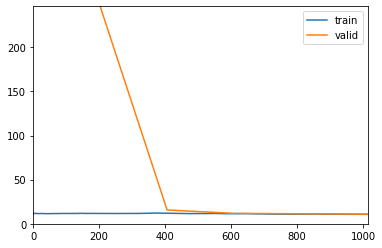

Better model found at epoch 0 with valid_loss value: 246.27700805664062.
Better model found at epoch 1 with valid_loss value: 15.657465934753418.
Better model found at epoch 2 with valid_loss value: 11.793469429016113.
Better model found at epoch 3 with valid_loss value: 11.311678886413574.
Better model found at epoch 4 with valid_loss value: 10.904807090759277.


In [376]:
lr = 2e-2
learn.fit_one_cycle(cyc_len=5, max_lr=slice(lr), wd=1e-3, pct_start=0.3, callbacks=[SaveModelCallback(learn)])

In [ ]:
predict = []
path = './test/'
pics = ['beard.jpg', 'alex.png', 'ant.png', 'halloween.jpg', 'jeremy.jpg', 'kristen.jpg', 'mom.jpg']
for x in pics: 
    print(path + x)
    img = open_image(path + x)
    z = learn.predict(img)
    print(z)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-06
Min loss divided by 10: 6.31E-08


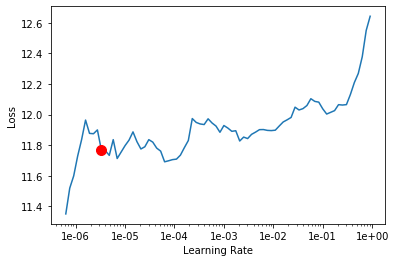

In [352]:
#Train full model
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion = True)

In [361]:
slice(1e-6, lr/5, lr/4)

slice(1e-06, 0.004, 0.005)

In [377]:
learn.fit_one_cycle(5, max_lr=slice(1e-6, lr/5), wd=1e-3, callbacks=[SaveModelCallback(learn)], pct_start=0.4)

ZeroDivisionError: division by zero

In [ ]:
predict = []
path = './test/'
pics = ['beard.jpg', 'alex.png', 'ant.png', 'halloween.jpg', 'jeremy.jpg', 'kristen.jpg', 'mom.jpg']
for x in pics: 
    print(path + x)
    img = open_image(path + x)
    z = learn.predict(img)
    print(z)

In [ ]:
learn.save('first_head_resnet34')
# learn.load('first_head_resnet34')

In [ ]:
data_full_big = (data_full_src.transform(tfms, size=256)
        .databunch(bs=64*2).normalize(imagenet_stats))

In [ ]:
learn.data = data_full_big
data_full_big.train_ds[0][0].shape

In [ ]:
learn.freeze_to(-1)
learn.lr_find()
learn.recorder.plot(suggestion = True)